# Generated Content Detector Project: AI generated photos vs real photos

### Unzipping ZIP files from Kaggle [dataset](https://www.kaggle.com/datasets/philosopher0808/real-vs-ai-generated-faces-dataset/data "open Kaggle dataset")

In [ ]:
zip_path = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/AI-face-detection-Dataset.zip"


extract_path = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/"


!mkdir -p {extract_path}

#Performing extraction
#q makes the output quieter
#d specifies the target directory
!unzip -q {zip_path} -d {extract_path}

print(f"File {zip_path} successfully extracted to {extract_path}")

File /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/AI-face-detection-Dataset.zip successfully extracted to /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/


### Import libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
import os
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
print(torch.cuda.is_available())
from PIL import Image

True


### Determine System Device to optimize performance: CPU or CUDA (VRAM) Checker

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


### Image Dataset Preparation with PyTorch
##### - Training Data: 1,600 images (800 AI + 800 real) - 80%
##### - Testing Data: 400 images (200 AI + 200 real) - 20%

In [ ]:
%%time
# --- 1. Define transforms ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- 2. Load dataset structure ---
dataset = datasets.ImageFolder("/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/AI-face-detection-Dataset/", transform=transform)

# dataset.class_to_idx → {'ai': 0, 'real': 1}

# --- 3. Split by class (real + ai separately) ---
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 80%
def split_class(indices, train_ratio=0.8):
    train_len = int(len(indices) * train_ratio)
    return indices[:train_len], indices[train_len:]

train_real, test_real = split_class(indices_real)
train_ai,   test_ai   = split_class(indices_ai)

# --- 4. Combine indices for train & test ---
train_indices = train_real + train_ai
test_indices  = test_real + test_ai

train_dataset = Subset(dataset, train_indices)
test_dataset  = Subset(dataset, test_indices)

# --- 5. Dataloaders ---
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader  = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# --- 6. Class names ---
classes = dataset.classes   # ['ai', 'real']

print("Train samples:", len(train_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

Train samples: 1600
Test samples: 401
Classes: ['AI', 'real_color']
CPU times: user 21.2 s, sys: 3.52 s, total: 24.8 s
Wall time: 1min 41s


### Display Randomly Selected Images with Classifications from the Trained Model

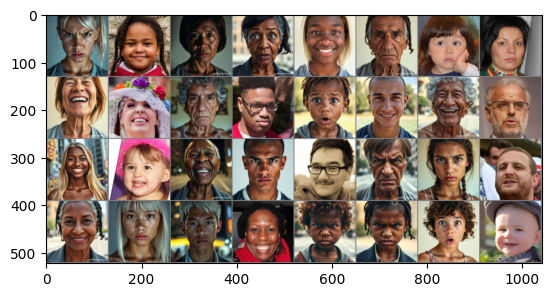

AI    real_color AI    AI    AI    AI    real_color real_color


In [ ]:
# functions to show an image
batch_size = 8
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network (CNN) for Image Classification
##### This code implements a convolutional neural network (CNN) class named Net, featuring two convolutional layers with pooling, followed by three fully connected layers. It is designed for binary image classification, effectively modeling the forward pass to process input images and output class predictions.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Flattened size: 16 channels * 29 * 29
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # Corrected input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  # Corrected output size for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# net = Net()             #CPU
net = Net().to(device)    #GPU


### Setting Up the Loss Function and Optimizer


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Training the Neural Network
##### This section of the code trains the neural network for 300 epochs, calculating and recording the training loss at each epoch. It utilizes a data loader to iterate through the training dataset, performs forward and backward passes, and updates the model weights using the defined optimizer.

In [ ]:
%%time
train_losses = []

for epoch in range(300):
    running_loss = 0.0

    for i, data in enumerate(trainloader):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, loss: {epoch_loss}")

print("Finished Training")

Epoch 1, loss: 1.554344369750993e-05
Epoch 2, loss: 1.540438645804443e-05
Epoch 3, loss: 1.535397797098881e-05
Epoch 4, loss: 1.5279077394332317e-05
Epoch 5, loss: 1.5228852457482845e-05
Epoch 6, loss: 1.5180505411649391e-05
Epoch 7, loss: 1.5156645776102096e-05
Epoch 8, loss: 1.5063958836805114e-05
Epoch 9, loss: 1.5026606735375481e-05
Epoch 10, loss: 1.4951194262060597e-05
Epoch 11, loss: 1.4866265489388298e-05
Epoch 12, loss: 1.4788755971935075e-05
Epoch 13, loss: 1.475180319104652e-05
Epoch 14, loss: 1.4689103325444818e-05
Epoch 15, loss: 1.4605667988156767e-05
Epoch 16, loss: 1.4555490056125109e-05
Epoch 17, loss: 1.4496112737703014e-05
Epoch 18, loss: 1.449126765521669e-05
Epoch 19, loss: 1.4421679722573799e-05
Epoch 20, loss: 1.4351553843834352e-05
Epoch 21, loss: 1.4271672876091657e-05
Epoch 22, loss: 1.421092546621594e-05
Epoch 23, loss: 1.4183906551181735e-05
Epoch 24, loss: 1.4099655054380378e-05
Epoch 25, loss: 1.4035222114259226e-05
Epoch 26, loss: 1.3991207483456946e-05
E

In [ ]:
# Another training model for a neural network.
# It sets up a DataLoader to handle the training dataset in batches and runs a training loop for 300 epochs, iterating over the dataset.
# The code calculates the running loss and prints statistics every 2000 mini-batches to monitor training progress.


#%%time
# trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

# for epoch in range(300):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data

#         #GPU
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')

Finished Training
CPU times: user 2min 28s, sys: 36.2 s, total: 3min 4s
Wall time: 56min 9s


### Visualizing Training Results: Improved Performance Across Epochs

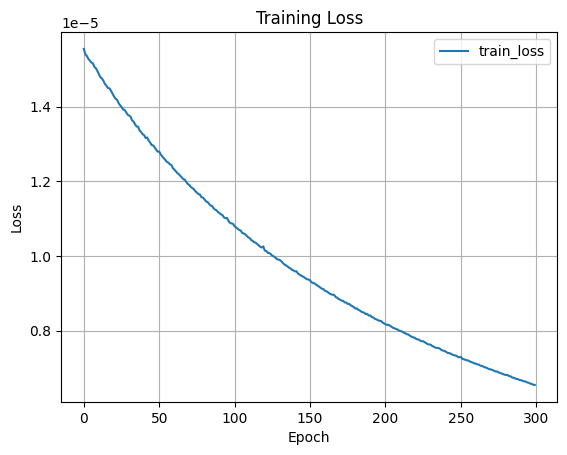

In [ ]:
def plot_history(train_losses):
    plt.figure()
    plt.plot(train_losses, label="train_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

# Assuming 'train_losses' list is available from previous training cell (e.g., b00LhdtfaTOQ)
if 'train_losses' in globals() and train_losses:
    plot_history(train_losses)
else:
    print("Error: 'train_losses' not found or is empty. Please run the training cell first.")

### Saving the Trained Model



In [ ]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net.pth'
torch.save(net.state_dict(), PATH)

### Testing the Network on Test Data



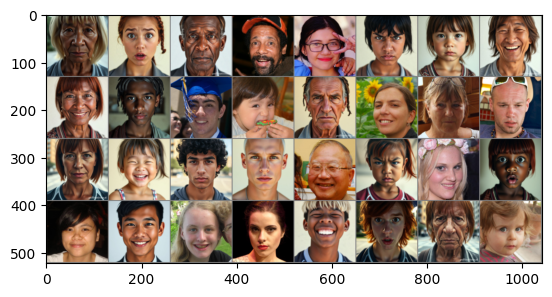

GroundTruth:  AI    AI    AI    real_color real_color AI    AI    AI   


In [ ]:
dataiter = iter(testloader)
print(dataiter)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

### Loading the Saved Model and Summary of Architecture
##### It highlights that the model has approximately 1.63 million trainable parameters, details the output shapes of each layer, and indicates an estimated total model size of about 7.79 MB. This information is essential for understanding the model's complexity and resource requirements.

In [ ]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
net.to(device) # Move the model to the GPU

summary(net, (3, 128, 128)) # Corrected input size for summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
         MaxPool2d-2            [-1, 6, 62, 62]               0
            Conv2d-3           [-1, 16, 58, 58]           2,416
         MaxPool2d-4           [-1, 16, 29, 29]               0
            Linear-5                  [-1, 120]       1,614,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 3]             255
Total params: 1,628,131
Trainable params: 1,628,131
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.39
Params size (MB): 6.21
Estimated Total Size (MB): 7.79
----------------------------------------------------------------


### Interpreting Model Outputs: Class Predictions
##### The outputs from the model represent energy levels for two classes, indicating the network's confidence in classifying an image. A higher energy value suggests a stronger belief that the image belongs to that specific class.

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  real_color real_color AI    real_color


### Evaluating Network Performance on the Entire Dataset

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move inputs to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 400 test images: {100 * correct // total} %')

Accuracy of the network on the 400 test images: 100 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move inputs to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: AI    is 100.0 %
Accuracy for class: real_color is 100.0 %


###### NOTE: The evaluation indicates that the network has achieved 100% accuracy on the entire dataset, which is likely due to overfitting since dataset is small and not diverse.
###### Validation: It's essential to validate performance on a separate test dataset to ensure the model generalizes well to unseen data.

### Displaying activations:
#### Let's try plotting the first channel of the first activation
###### Visualizing activations is essential for understanding how a neural network processes input data and learns features at various layers. It helps reveal which aspects of the data the model focuses on, aiding in debugging potential issues such as vanishing gradients. Additionally, this visualization enhances interpretability by providing insights into the model's decision-making process, fostering trust and transparency in its predictions.

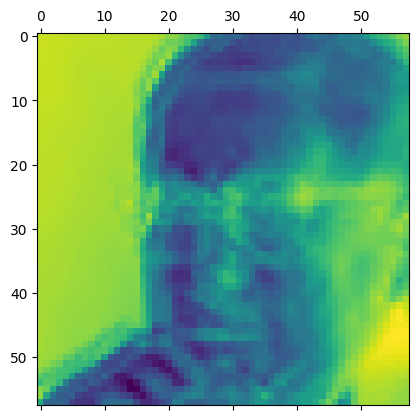

In [ ]:
first_activation = layer_activation[0]
first_activation.shape
plt.matshow(first_activation[0, :, :], cmap='viridis') # Corrected indexing

#### Green and yellow areas indicate strong activations, suggesting that the model is detecting significant features of the face. The yellow areas specifically highlight the most prominent facial features, such as eyes and mouth, which are crucial for facial recognition tasks. This visualization helps in understanding how the model focuses on essential aspects of the input data.

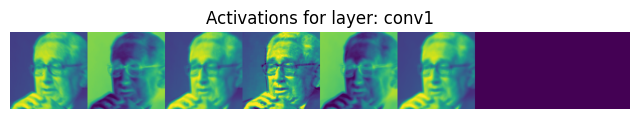

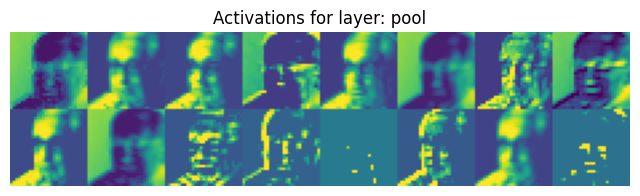

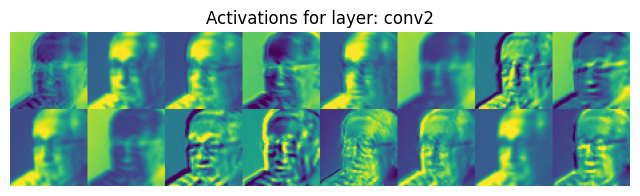

In [ ]:
# Assuming 'net' is the trained model and 'device' is defined.
# Assuming 'images' (a batch of input images) is available from a dataloader.

# Ensure the model is in evaluation mode
net.eval()

# Dictionary to store activations
activations_storage = {}

# Define a hook function to capture the output of layers
def get_activation(name):
    def hook(model, input, output):
        activations_storage[name] = output
    return hook

# Register hooks for the convolutional and pooling layers
# We iterate through named_children to get both the name and the module
hook_handles = []
layer_names_for_plotting = []
for name, layer in net.named_children():
    # Only register hooks for Conv2d and MaxPool2d layers that produce feature maps
    if isinstance(layer, (nn.Conv2d, nn.MaxPool2d)):
        handle = layer.register_forward_hook(get_activation(name))
        hook_handles.append(handle)
        layer_names_for_plotting.append(name)

# Perform a forward pass with a single image to populate activations_storage
# Take the first image from the 'images' batch and add a batch dimension
single_image = images[0].unsqueeze(0).to(device)

with torch.no_grad(): # No need to compute gradients for visualization
    _ = net(single_image)

# Remove the hooks after use to clean up
for handle in hook_handles:
    handle.remove()

images_per_row = 8

# Now, iterate through the captured activations and plot
for layer_name in layer_names_for_plotting:
    if layer_name not in activations_storage:
        print(f"Warning: No activation found for layer {layer_name}. Skipping.")
        continue

    layer_activation = activations_storage[layer_name]

    # Ensure layer activation is a tensor and move to CPU for numpy conversion
    if isinstance(layer_activation, torch.Tensor):
        layer_activation = layer_activation.detach().cpu()

    # The activation shape is (batch_size, channels, height, width)
    # We are visualizing the first image in the batch (index 0)
    # Extract the activation map for the first image
    first_image_activation = layer_activation[0] # Shape (channels, height, width)

    n_features = first_image_activation.shape[0] # Number of channels
    size = first_image_activation.shape[1]    # Height/Width (assuming square)

    # Calculate number of columns needed based on images_per_row
    # Use ceiling division to ensure all features are covered
    n_cols = (n_features + images_per_row - 1) // images_per_row
    if n_cols == 0: # Handle edge case for layers with very few features
        n_cols = 1 # At least one row if there are any features

    # Create an empty grid to display the channel images
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_idx = col * images_per_row + row
            if channel_idx < n_features: # Ensure we don't go out of bounds for features
                # Extract the 2D activation map for the current channel
                channel_image = first_image_activation[channel_idx, :, :].numpy()

                # Post-process for visualization: normalize and scale
                # This makes the features more visible
                channel_image -= channel_image.mean()
                if channel_image.std() != 0: # Avoid division by zero
                    channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')

                # Place the processed channel image into the display grid
                display_grid[
                    col * size : (col + 1) * size,
                    row * size : (row + 1) * size
                ] = channel_image

    # Plotting
    scale = 1. / size # Adjust scale for better display
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(f'Activations for layer: {layer_name}')
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

### Evaluating Model Performance on an Out-of-Dataset Image:

In [ ]:
# Step 1: Define the EXACT model architecture from training
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Flattened size: 16 channels * 29 * 29
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # Corrected input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)  # 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Step 2: Load the trained model
def load_model(model_path, device='cpu'):
    """Load the trained model from .pth file"""
    model = Net().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode
    return model


# Step 3: Preprocess the image (CRITICAL: Must be 128x128!)
def preprocess_image(image_path, target_size=(128, 128)):
    """Load and preprocess a single image"""
    # Define transforms - adjust normalization if you used different values during training
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor


# Step 4: Make prediction
def predict(model, image_tensor, device='cpu'):
    """Run inference on the preprocessed image"""
    image_tensor = image_tensor.to(device)

    with torch.no_grad():  # Disable gradient computation
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1)

    return predicted_class.item(), probabilities[0].cpu().numpy()


# Step 5: Main testing function
def test_single_image(model_path, image_path, class_labels=None, device=None):
    """Complete pipeline to test model on a single image"""
    # Set device
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Default class labels (adjust based on your training)
    if class_labels is None:
        class_labels = {
            0: "Class 0",
            1: "Class 1",

        }

    # Load model
    print(f"Loading model from {model_path}...")
    model = load_model(model_path, device)

    # Preprocess image
    print(f"Processing image: {image_path}")
    image_tensor = preprocess_image(image_path)

    # Make prediction
    print("Running inference...")
    predicted_class, probabilities = predict(model, image_tensor, device)

    # Display results
    print("\n" + "="*60)
    print("RESULTS:")
    print("="*60)
    print(f"Predicted Class: {class_labels.get(predicted_class, f'Class {predicted_class}')} (Class {predicted_class})")
    print(f"\nProbabilities:")
    for i, prob in enumerate(probabilities):
        label = class_labels.get(i, f"Class {i}")
        print(f"  {label}: {prob:.4f} ({prob*100:.2f}%)")
    print("="*60)

    return predicted_class, probabilities


# Example usage
if __name__ == "__main__":
    # Define your class labels (IMPORTANT: Replace these with your actual class names)
    # Make sure you have exactly 3 labels since your model has 3 output classes
    CLASS_LABELS = {
        0: "AI-Generated",
        1: "Real Photo",

    }

    # Paths
    MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net.pth"
    IMAGE_PATH = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/AI-face-detection-Dataset/AI/999_20241130180834_A_close-up_shot_of_a_child_non-binary_person_of_Hi.jpg"

    # Run test
    try:
        predicted_class, probabilities = test_single_image(
            MODEL_PATH,
            IMAGE_PATH,
            class_labels=CLASS_LABELS
        )

        print(f"Prediction complete!")
        print(f"The image is classified as: {CLASS_LABELS[predicted_class]}")

    except FileNotFoundError as e:
        print(f" Error: {e}")
        print("Please check that the model and image paths are correct.")
    except Exception as e:
        print(f" An error occurred: {e}")
        import traceback
        traceback.print_exc()

Using device: cuda
Loading model from /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/ai_real_net.pth...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector/AI-face-detection-Dataset/AI/999_20241130180834_A_close-up_shot_of_a_child_non-binary_person_of_Hi.jpg
Running inference...

RESULTS:
Predicted Class: AI-Generated (Class 0)

Probabilities:
  AI-Generated: 0.9509 (95.09%)
  Real Photo: 0.0491 (4.91%)
  Class 2: 0.0000 (0.00%)
Prediction complete!
The image is classified as: AI-Generated


#### SUMMARY: The evaluation revealed that the model struggled to correctly classify AI-generated photos from an external dataset, incorrectly labeling all images as real. In contrast, when tested with a single photo from its own dataset, the model demonstrated strong performance, achieving an accurate prediction with 95% probability. This discrepancy highlights the need to expand and diversify the dataset to improve the model's ability to recognize and differentiate between AI-generated and real images effectively. By incorporating a broader range of examples, the model's robustness and accuracy can be significantly enhanced.